In [1]:
!pip install faiss-gpu

In [2]:
!pip install datasets

In [3]:
from datasets import load_dataset

issues_dataset = load_dataset("lewtun/github-issues", split="train")
issues_dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Repo card metadata block was not found. Setting CardData to empty.


Dataset({
    features: ['url', 'repository_url', 'labels_url', 'comments_url', 'events_url', 'html_url', 'id', 'node_id', 'number', 'title', 'user', 'labels', 'state', 'locked', 'assignee', 'assignees', 'milestone', 'comments', 'created_at', 'updated_at', 'closed_at', 'author_association', 'active_lock_reason', 'pull_request', 'body', 'timeline_url', 'performed_via_github_app', 'is_pull_request'],
    num_rows: 3019
})

In [4]:
issues_dataset = issues_dataset.filter(
    lambda x: (x["is_pull_request"] == False and len(x["comments"]) > 0)
)
issues_dataset

Dataset({
    features: ['url', 'repository_url', 'labels_url', 'comments_url', 'events_url', 'html_url', 'id', 'node_id', 'number', 'title', 'user', 'labels', 'state', 'locked', 'assignee', 'assignees', 'milestone', 'comments', 'created_at', 'updated_at', 'closed_at', 'author_association', 'active_lock_reason', 'pull_request', 'body', 'timeline_url', 'performed_via_github_app', 'is_pull_request'],
    num_rows: 808
})

In [5]:
columns = issues_dataset.column_names
columns_to_keep = ["title", "body", "html_url", "comments"]
columns_to_remove = set(columns_to_keep).symmetric_difference(columns)
issues_dataset = issues_dataset.remove_columns(columns_to_remove)
issues_dataset

Dataset({
    features: ['html_url', 'title', 'comments', 'body'],
    num_rows: 808
})

In [6]:
issues_dataset.set_format("pandas")
df = issues_dataset[:]

In [7]:
df["comments"][0].tolist()

['Cool, I think we can do both :)',
 '@lhoestq now the 2 are implemented.\r\n\r\nPlease note that for the the second protection, finally I have chosen to protect the master branch only from **merge commits** (see update comment above), so no need to disable/re-enable the protection on each release (direct commits, different from merge commits, can be pushed to the remote master branch; and eventually reverted without messing up the repo history).']

In [8]:
comments_df = df.explode("comments", ignore_index=True)
comments_df.head(4)

,html_url,title,comments,body
0,https://github.com/huggingface/datasets/issues...,Protect master branch,"Cool, I think we can do both :)",After accidental merge commit (91c55355b634d0d...
1,https://github.com/huggingface/datasets/issues...,Protect master branch,@lhoestq now the 2 are implemented.\r\n\r\nPle...,After accidental merge commit (91c55355b634d0d...
2,https://github.com/huggingface/datasets/issues...,Backwards compatibility broken for cached data...,Hi ! I guess the caching mechanism should have...,## Describe the bug\r\nAfter upgrading to data...
3,https://github.com/huggingface/datasets/issues...,Backwards compatibility broken for cached data...,"If it's easy enough to implement, then yes ple...",## Describe the bug\r\nAfter upgrading to data...


In [9]:
from datasets import Dataset

comments_dataset = Dataset.from_pandas(comments_df)
comments_dataset

Dataset({
    features: ['html_url', 'title', 'comments', 'body'],
    num_rows: 2964
})

In [10]:
comments_dataset = comments_dataset.map(
    lambda x: {"comment_length": len(x["comments"].split())}
)

Map:   0%|          | 0/2964 [00:00<?, ? examples/s]

In [11]:
comments_dataset = comments_dataset.filter(lambda x: x["comment_length"] > 15)
comments_dataset

Filter:   0%|          | 0/2964 [00:00<?, ? examples/s]

Dataset({
    features: ['html_url', 'title', 'comments', 'body', 'comment_length'],
    num_rows: 2175
})

In [12]:
def concatenate_text(examples):
    return {
        "text": examples["title"]
        + " \n "
        + examples["body"]
        + " \n "
        + examples["comments"]
    }


comments_dataset = comments_dataset.map(concatenate_text)
comments_dataset

Map:   0%|          | 0/2175 [00:00<?, ? examples/s]

Dataset({
    features: ['html_url', 'title', 'comments', 'body', 'comment_length', 'text'],
    num_rows: 2175
})

In [13]:
from transformers import AutoTokenizer, AutoModel

model_ckpt = "sentence-transformers/multi-qa-mpnet-base-dot-v1"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

In [14]:
import torch

device = torch.device("cuda")
model.to(device)

MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [15]:
def cls_pooling(model_output):
    return model_output.last_hidden_state[:, 0]

In [16]:
def get_embeddings(text_list):
    encoded_input = tokenizer(
        text_list, padding=True, truncation=True, return_tensors="pt"
    )
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    model_output = model(**encoded_input)
    return cls_pooling(model_output)

In [17]:
embedding = get_embeddings(comments_dataset["text"][0])
embedding.shape

torch.Size([1, 768])

In [18]:
embeddings_dataset = comments_dataset.map(
    lambda x: {"embeddings": get_embeddings(x["text"]).detach().cpu().numpy()[0]}
)

Map:   0%|          | 0/2175 [00:00<?, ? examples/s]

In [19]:
embeddings_dataset.add_faiss_index(column="embeddings")

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['html_url', 'title', 'comments', 'body', 'comment_length', 'text', 'embeddings'],
    num_rows: 2175
})

In [20]:
question = "How can I load a dataset offline?"
question_embedding = get_embeddings([question]).cpu().detach().numpy()
question_embedding.shape

(1, 768)

In [21]:
scores, samples = embeddings_dataset.get_nearest_examples(
    "embeddings", question_embedding, k=5
)

In [22]:
import pandas as pd

samples_df = pd.DataFrame.from_dict(samples)
samples_df["scores"] = scores
samples_df.sort_values("scores", ascending=False, inplace=True)

In [23]:
for _, row in samples_df.iterrows():
    print(f"COMMENT: {row.comments}")
    print(f"SCORE: {row.scores}")
    print(f"TITLE: {row.title}")
    print(f"URL: {row.html_url}")
    print("=" * 50)
    print()

COMMENT: Requiring online connection is a deal breaker in some cases unfortunately so it'd be great if offline mode is added similar to how `transformers` loads models offline fine.

@mandubian's second bullet point suggests that there's a workaround allowing you to use your offline (custom?) dataset with `datasets`. Could you please elaborate on how that should look like?
SCORE: 25.505016326904297
TITLE: Discussion using datasets in offline mode
URL: https://github.com/huggingface/datasets/issues/824

COMMENT: The local dataset builders (csv, text , json and pandas) are now part of the `datasets` package since #1726 :)
You can now use them offline
```python
datasets = load_dataset('text', data_files=data_files)
```

We'll do a new release soon
SCORE: 24.555538177490234
TITLE: Discussion using datasets in offline mode
URL: https://github.com/huggingface/datasets/issues/824

COMMENT: I opened a PR that allows to reload modules that have already been loaded once even if there's no intern

In [26]:
dataset = load_dataset("sentence-transformers/squad")

In [27]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 87599
    })
})

In [33]:
from sentence_transformers import SentenceTransformer

In [34]:
model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.71k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [35]:
device = torch.device("cuda")
model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [36]:
questions = dataset['train']['question']
answers = dataset['train']['answer']

In [52]:
answers = list(set(answers))

In [53]:
len(answers)

18891

In [54]:
question_embeddings = model.encode(questions, convert_to_tensor=True)
answer_embeddings = model.encode(answers, convert_to_tensor=True)

print("Osadzenia zapytań:", question_embeddings.shape)
print("Osadzenia odpowiedzi:", answer_embeddings.shape)

Osadzenia zapytań: torch.Size([87599, 768])
Osadzenia odpowiedzi: torch.Size([18891, 768])


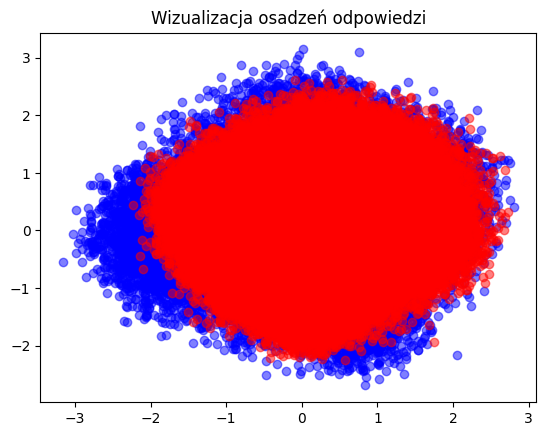

In [55]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_embeddings_a = pca.fit_transform(answer_embeddings.cpu().numpy())
reduced_embeddings_q = pca.fit_transform(question_embeddings.cpu().numpy())

plt.scatter(reduced_embeddings_a[:, 0], reduced_embeddings_a[:, 1], alpha=0.5, color="blue")
plt.scatter(reduced_embeddings_q[:, 0], reduced_embeddings_q[:, 1], alpha=0.5, color="red")

plt.title("Wizualizacja osadzeń odpowiedzi")
plt.show()


In [56]:
top_k = 5

In [57]:
for question in questions[:10]:
  question_embedding = model.encode(question, convert_to_tensor=True)
  similarity_scores = model.similarity(question_embedding, answer_embeddings)[0]
  scores, indices = torch.topk(similarity_scores, k=top_k)

  print("\nQuery:", question)
  print("Top 5 most similar sentences in corpus:")

  for score, idx in zip(scores, indices):
      print(answers[idx], f"(Score: {score:.4f})")



Query: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Top 5 most similar sentences in corpus:
Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary. (Score: 21.6458)
The Gospel of Luke begins its account of Mary's life with the Annunciation, when the angel Gabriel appeared to her and announced her divine selection to be the mother 